<a href="https://colab.research.google.com/github/Vakhranev/Compling/blob/master/Vakhranyov_AY_Deep_learning_Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом проекте я постарался с помощью предобученного берта сделать предсказания для текста на сентимент-анализ. Я взял датасет Sentiment Analysis Dataset.csv он есть здесь (https://github.com/vineetdhanawat/twitter-sentiment-analysis/blob/master/datasets/Sentiment%20Analysis%20Dataset.csv). Пояснений к нему, к сожалению, нет, поэтому точно сказать не могу, но, судя по всему, представленные в нём разбиты следующим образом: целевой класс (представлены единицей) — твиты с положительно-окрашенным мнением, всё остальное — представлено нулями. Помимо того, что я попробовал замерять лоссы на эпохах, также я использовал ф-меру для оценки модели.

В последнее время применение глубокого обучения для решения проблемы сентимент-анализа стало популярной темой исследований. Существуют различные архитектуры глубокого обучения и технологии, которые применяют для подобного рода анализа: эмбеддинги, автоэнкодеры, CNN, RNN, LSTM, применение аттеншн-механизма в RNN, MemNN, RecNN. Многие из этих методов глубокого обучения показали отличные результаты для различных задач сентимент-анализа. Если верить научным работам по теме, которые я просмотрел, то с развитием исследований и приложений глубокого обучения в ближайшем будущем появятся более интересные исследования применения глубокого обучения для сентимент-анализа.

In [127]:
!pip install transformers
import pandas as pd
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
data = pd.read_csv("Sentiment Analysis Dataset.csv", header= None)
max_len = 512

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
data = data[:500]
data.columns = ["id", "sentiment", "text"]

In [129]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data["id"] = label_encoder.fit_transform(data["id"])
data["sentiment"] = label_encoder.fit_transform(data["sentiment"])
data["text"] = label_encoder.fit_transform(data["text"])

In [130]:
data.head

<bound method NDFrame.head of       id  sentiment  text
0    499          2   499
1      0          0     2
2    111          0     3
3    222          1     6
4    333          0     9
..   ...        ...   ...
495  439          1   432
496  440          0   459
497  441          0   460
498  442          1   185
499  443          0   320

[500 rows x 3 columns]>

In [131]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.1, random_state=42)

In [132]:
from torch.utils.data import Dataset
class dataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):   
        text = str(self.texts[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True,max_length=self.max_len, return_token_type_ids=False,padding='max_length', return_attention_mask=True, return_tensors='pt', truncation = True)
        return {'text': text, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'targets': torch.tensor(target, dtype=torch.long)}

In [133]:
import numpy as np
from torch.utils.data import DataLoader
def fn_Dataloader(data, tokenizer, max_len, batch_size):
    ds = dataset(data.text.to_numpy(), data.sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds,batch_size=batch_size)

batch_size = 8
loader = fn_Dataloader(train, tokenizer, max_len, batch_size)
test_loader = fn_Dataloader(test, tokenizer, max_len, batch_size)

In [134]:
print(type(loader))

torch.utils.data.dataloader.DataLoader


In [135]:
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)

In [136]:
from torch import nn
class Classifier(torch.nn.Module):
    
    def __init__(self,n_classes):
        super(Classifier, self).__init__()
        self.bert = model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [137]:
model = Classifier(3)

In [138]:
epochs = 6
for param in model.parameters():
    param.requires_grad = False
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [139]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from statistics import mean
train_losses = list()
train_loss_per_epoch = list()
test_loss_per_epoch = list()
for epoch in range(epochs):
    train_epoch_losses = list()
    test_epoch_losses = list()
    train_f1s = list()
    test_f1s = list()
    print(f'Epoch: {epoch}')
    model.train()
    for element in tqdm(loader):
        x = element["input_ids"]
        mask_train = element["attention_mask"]
        y = element["targets"]
        outputs = model(input_ids=x,attention_mask=mask_train)
        _, preds = torch.max(outputs, dim=1)
        train_loss = loss(outputs, y)
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(train_loss.item())
        train_epoch_losses.append(train_loss.item())
        train_f1s.append(f1_score(y, outputs.argmax(1), average='micro'))
    model.eval()
    for element in tqdm(test_loader):
        x = element["input_ids"]
        mask_test = element["attention_mask"]
        y = element["targets"]
        with torch.no_grad():
            outputs_test = model(input_ids=x,attention_mask=mask_test)
            _, preds_test = torch.max(outputs_test, dim=1)
            test_loss = loss(outputs_test, y)
        test_epoch_losses.append(test_loss.item())
    train_loss_per_epoch.append(np.mean(train_epoch_losses))
    test_loss_per_epoch.append(np.mean(test_epoch_losses))
    test_f1s.append(f1_score(y, outputs_test.argmax(1), average='micro'))
    mean_train = mean(train_f1s)
    mean_test = mean(test_f1s)
    print(f'Epoch {epoch}')
    print(f'Loss: train {train_loss_per_epoch[-1]:.2f} | test {test_loss_per_epoch[-1]:.2f}')
    print(f'F1: train {mean_train} | test {mean_test}')
























  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 0

























  2%|▏         | 1/57 [00:16<15:11, 16.27s/it]






















  4%|▎         | 2/57 [00:33<15:14, 16.63s/it]






















  5%|▌         | 3/57 [00:49<14:43, 16.36s/it]






















  7%|▋         | 4/57 [01:05<14:16, 16.16s/it]






















  9%|▉         | 5/57 [01:20<13:54, 16.04s/it]






















 11%|█         | 6/57 [01:36<13:32, 15.93s/it]






















 12%|█▏        | 7/57 [01:52<13:12, 15.86s/it]






















 14%|█▍        | 8/57 [02:08<12:54, 15.81s/it]






















 16%|█▌        | 9/57 [02:23<12:37, 15.78s/it]






















 18%|█▊        | 10/57 [02:39<12:20, 15.76s/it]






















 19%|█▉        | 11/57 [02:55<12:03, 15.73s/it]






















 21%|██        | 12/57 [03:10<11:47, 15.72s/it]






















 23%|██▎       | 13/57 [03:26<11:31, 15.71s/it]






















 25%|██▍       | 14/57 [03:42<11:15, 15.71s/it]






















 26%|█

Epoch 0
Loss: train 1.03 | test 1.09
F1: train 0.42543859649122806 | test 0.0
Epoch: 1

























  2%|▏         | 1/57 [00:15<14:39, 15.71s/it]






















  4%|▎         | 2/57 [00:31<14:24, 15.72s/it]






















  5%|▌         | 3/57 [00:47<14:10, 15.75s/it]






















  7%|▋         | 4/57 [01:02<13:54, 15.74s/it]






















  9%|▉         | 5/57 [01:18<13:37, 15.72s/it]






















 11%|█         | 6/57 [01:34<13:21, 15.72s/it]






















 12%|█▏        | 7/57 [01:50<13:05, 15.71s/it]






















 14%|█▍        | 8/57 [02:05<12:50, 15.73s/it]






















 16%|█▌        | 9/57 [02:21<12:34, 15.72s/it]






















 18%|█▊        | 10/57 [02:37<12:18, 15.72s/it]






















 19%|█▉        | 11/57 [02:52<12:02, 15.71s/it]






















 21%|██        | 12/57 [03:08<11:46, 15.71s/it]






















 23%|██▎       | 13/57 [03:24<11:31, 15.71s/it]






















 25%|██▍       | 14/57 [03:40<11:15, 15.71s/it]






















 26%|█

Epoch 1
Loss: train 1.05 | test 1.09
F1: train 0.40789473684210525 | test 0.0
Epoch: 2

























  2%|▏         | 1/57 [00:15<14:38, 15.69s/it]






















  4%|▎         | 2/57 [00:31<14:23, 15.71s/it]






















  5%|▌         | 3/57 [00:47<14:07, 15.70s/it]






















  7%|▋         | 4/57 [01:02<13:52, 15.70s/it]






















  9%|▉         | 5/57 [01:18<13:36, 15.70s/it]






















 11%|█         | 6/57 [01:34<13:20, 15.70s/it]






















 12%|█▏        | 7/57 [01:49<13:05, 15.71s/it]






















 14%|█▍        | 8/57 [02:05<12:50, 15.73s/it]






















 16%|█▌        | 9/57 [02:21<12:34, 15.73s/it]






















 18%|█▊        | 10/57 [02:37<12:18, 15.72s/it]






















 19%|█▉        | 11/57 [02:52<12:03, 15.72s/it]






















 21%|██        | 12/57 [03:08<11:46, 15.71s/it]






















 23%|██▎       | 13/57 [03:24<11:31, 15.71s/it]






















 25%|██▍       | 14/57 [03:39<11:15, 15.71s/it]






















 26%|█

Epoch 2
Loss: train 1.03 | test 1.10
F1: train 0.42543859649122806 | test 0.0
Epoch: 3

























  2%|▏         | 1/57 [00:15<14:41, 15.74s/it]






















  4%|▎         | 2/57 [00:31<14:25, 15.73s/it]






















  5%|▌         | 3/57 [00:47<14:08, 15.72s/it]






















  7%|▋         | 4/57 [01:02<13:52, 15.71s/it]






















  9%|▉         | 5/57 [01:18<13:37, 15.72s/it]






















 11%|█         | 6/57 [01:34<13:22, 15.73s/it]






















 12%|█▏        | 7/57 [01:50<13:06, 15.73s/it]






















 14%|█▍        | 8/57 [02:05<12:50, 15.73s/it]






















 16%|█▌        | 9/57 [02:21<12:34, 15.73s/it]






















 18%|█▊        | 10/57 [02:38<12:42, 16.22s/it]






















 19%|█▉        | 11/57 [02:54<12:19, 16.08s/it]






















 21%|██        | 12/57 [03:10<11:58, 15.97s/it]






















 23%|██▎       | 13/57 [03:26<11:39, 15.90s/it]






















 25%|██▍       | 14/57 [03:41<11:21, 15.84s/it]






















 26%|█

Epoch 3
Loss: train 1.04 | test 1.09
F1: train 0.45394736842105265 | test 0.0
Epoch: 4

























  2%|▏         | 1/57 [00:15<14:39, 15.71s/it]






















  4%|▎         | 2/57 [00:31<14:24, 15.71s/it]






















  5%|▌         | 3/57 [00:47<14:08, 15.71s/it]






















  7%|▋         | 4/57 [01:02<13:52, 15.72s/it]






















  9%|▉         | 5/57 [01:18<13:37, 15.72s/it]






















 11%|█         | 6/57 [01:34<13:21, 15.72s/it]






















 12%|█▏        | 7/57 [01:50<13:05, 15.71s/it]






















 14%|█▍        | 8/57 [02:05<12:50, 15.73s/it]






















 16%|█▌        | 9/57 [02:21<12:34, 15.72s/it]






















 18%|█▊        | 10/57 [02:37<12:18, 15.71s/it]






















 19%|█▉        | 11/57 [02:52<12:02, 15.70s/it]






















 21%|██        | 12/57 [03:08<11:47, 15.72s/it]






















 23%|██▎       | 13/57 [03:24<11:31, 15.71s/it]






















 25%|██▍       | 14/57 [03:40<11:16, 15.73s/it]






















 26%|█

Epoch 4
Loss: train 1.03 | test 1.08
F1: train 0.43859649122807015 | test 0.0
Epoch: 5

























  2%|▏         | 1/57 [00:15<14:38, 15.69s/it]






















  4%|▎         | 2/57 [00:33<14:52, 16.23s/it]






















  5%|▌         | 3/57 [00:48<14:28, 16.08s/it]






















  7%|▋         | 4/57 [01:04<14:07, 15.98s/it]






















  9%|▉         | 5/57 [01:20<13:47, 15.91s/it]






















 11%|█         | 6/57 [01:36<13:28, 15.86s/it]






















 12%|█▏        | 7/57 [01:51<13:10, 15.81s/it]






















 14%|█▍        | 8/57 [02:07<12:53, 15.78s/it]






















 16%|█▌        | 9/57 [02:23<12:36, 15.76s/it]






















 18%|█▊        | 10/57 [02:38<12:19, 15.74s/it]






















 19%|█▉        | 11/57 [02:54<12:05, 15.76s/it]






















 21%|██        | 12/57 [03:10<11:49, 15.76s/it]






















 23%|██▎       | 13/57 [03:26<11:32, 15.75s/it]






















 25%|██▍       | 14/57 [03:41<11:16, 15.73s/it]






















 26%|█

Epoch 5
Loss: train 1.03 | test 1.11
F1: train 0.43640350877192985 | test 0.0


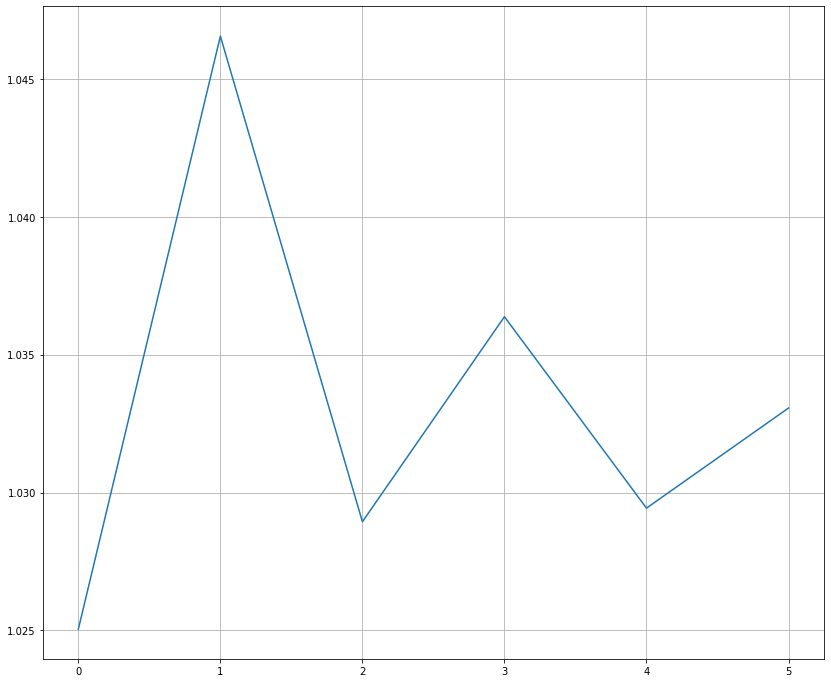

In [140]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(train_loss_per_epoch)
plt.grid()

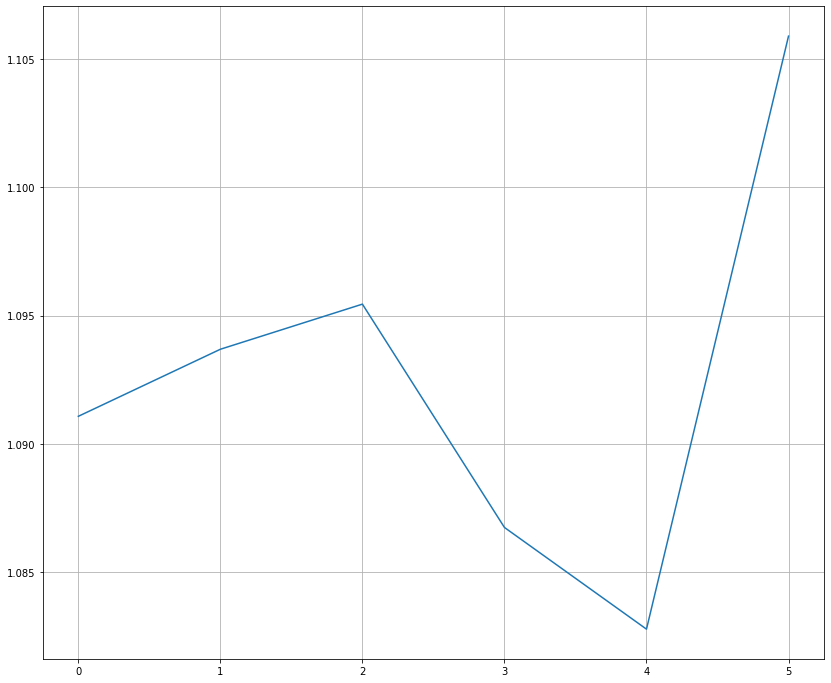

In [141]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(test_loss_per_epoch)
plt.grid()

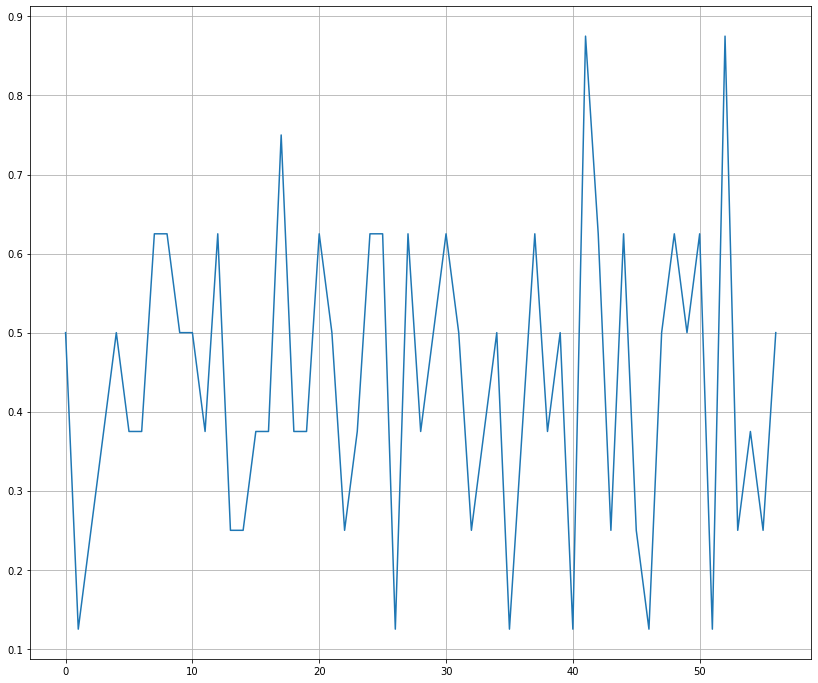

In [145]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(train_f1s)
plt.grid()

In [146]:
print('Лучшая метрика на test:')
print('Loss: ', min(test_loss_per_epoch))

Лучшая метрика на test:
Loss:  1.0827883652278356


Я выдающимися знаниями особо никогда не блистал, поэтому для меня даже достаточно простая задача (если сравнивать с другими вариантами проектов) давалась непросто. Наверное, главная проблема, с которой я столкнулся — это подсчёт ф-меры на тесте. На любом количестве — даже на сотнях и десятках тысяч я упорно получал нули после каждой эпохи. В причнах этой проблемы, к сожалению, мне разобраться не удалось. Полагаю, что это может быть связано с не самой очевидной разметкой данных в датасете. Я пробовал увеличивать количество эпох обучения, но результат не менялся. Уменьшать learning rate я не стал, потому что по умолчанию он и так стоит небольшой, вряд ли это помогло бы с решением проблемы.
Ф-мера на трейне вела себя довольно хаотично. Также, как видно на графиках, на 6 (последней) эпохе резко портятся лоссы (особенно на тесте), что, вероятнее всего, свидетельствует о переобучении модели. Думаю, что на таком количестве данных оптимально было бы остановиться на 5 эпохах.